## Fine Tune mentalBert or Robert large for classification

Fine tune to classify stress or no stress using messages from
Dreaddit: A Reddit Dataset for Stress Analysis in Social Media.
See: https://aclanthology.org/D19-6213

Uses HuggingFace to load models. Update: login('put your User Access Tokens here')

To change models update:

```tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-large")```

and

```model = AutoModelForSequenceClassification.from_pretrained(
    "FacebookAI/xlm-roberta-large",
    problem_type="single_label_classification",                    
    num_labels=N_labels,  
    device_map={"": 0}
)```

In [ ]:
!pip install transformers
!pip install datasets # extension of the transformers library

In [ ]:
# import torch
import pandas as pd
import time
from transformers import (
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    TextClassificationPipeline)

In [ ]:
# Set start time for training
start_time = time.time()

#### Logon to HuggingFace

In [ ]:
### the safer way
#from huggingface_hub import notebook_login
#notebook_login()

### alternative
from huggingface_hub import login
login('put your User Access Tokens here') # put your User Access Tokens here

#### Load messages, dropping nulls and sorting on date created.


In [ ]:
# URL of the raw CSV file on GitHub
csv_url = "https://raw.githubusercontent.com/SocialHealthAI/SDOH-Models/refs/heads/main/LLM%20Classification/dreaddit-train.csv"

# Load the CSV file into a DataFrame
train_df = pd.read_csv(csv_url)
train_df = train_df.head(2400)             # shorten training time
#dreadit_text_df = dreadit_df[['text']]

# URL of the raw CSV file on GitHub
csv_url = "https://raw.githubusercontent.com/SocialHealthAI/SDOH-Models/refs/heads/main/LLM%20Classification/dreaddit-test.csv"

# Load the CSV file into a DataFrame
test_df = pd.read_csv(csv_url)
test_df = test_df.head(400)             # shorten training time
#dreadit_text_df = dreadit_df[['text']]

# drop null text
train_df.dropna(subset=['text'], inplace=True)
test_df.dropna(subset=['text'], inplace=True)


In [ ]:
label_names = ['0', '1']

#### Split test data into test and validation data

In [ ]:
# Calculate the split index
split_index = len(test_df) // 2

# Split the DataFrame
validation_df = test_df.iloc[:split_index]
test_df = test_df.iloc[split_index:]


#### Set up Tokenizer

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

#tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-large")
tokenizer

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

XLMRobertaTokenizerFast(name_or_path='FacebookAI/xlm-roberta-large', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)

#### Encode training and validation data

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(validation_df['text'].values.tolist())
#test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

#### Create datasets and dataloaders

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(validation_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([2400]), torch.Size([200]), torch.Size([200]))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

#test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
#test_sampler = SequentialSampler(test_dataset)
#test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

#### Load Model using HuggingFace

In [ ]:
from transformers import BertForSequenceClassification
N_labels = len(train_df.label.unique())

model = AutoModelForSequenceClassification.from_pretrained(
    # "mental/mental-bert-base-uncased",
    "FacebookAI/xlm-roberta-large",
    problem_type="single_label_classification",                                # added, why? its binary
    num_labels=N_labels,  # Number of output labels
    device_map={"": 0}  # Optional dictionary specifying device mapping (single GPU with index 0 here)
)

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Model on GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

#### Fine TuningHyperparameters

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 4  #training and validation loss intersect at 2
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

#### Fine Tuning

In [ ]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(validation_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

150/150 train loss: 0.6727298398812612 
13/13 val loss: 0.596075741144327 
Epoch:  2


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

150/150 train loss: 0.5850272373358408 
13/13 val loss: 0.5428991111425253 
Epoch:  3


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

150/150 train loss: 0.515302284359932 
13/13 val loss: 0.5119662651648889 
Epoch:  4


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

150/150 train loss: 0.4645210747917493 
13/13 val loss: 0.4996067927433894 


In [ ]:
# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Time required by training: {elapsed_time:.4f} seconds")

Time required by training: 465.6923 seconds


#### Plot training and validation loss

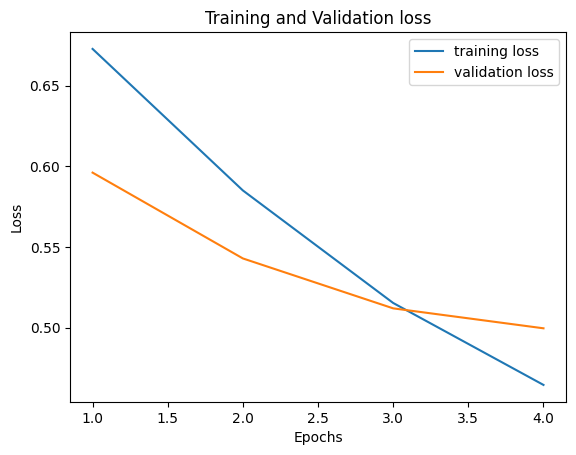

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

#### Classification metrics

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, validation_df['label'].to_numpy(), target_names=label_names))

classifiation report
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        88
           1       0.83      0.79      0.81       112

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



#### Save model and tokenizer

In [ ]:
# Define the directory to save the model and tokenizer
save_directory = "./fine_tuned_bert_model"

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./fine_tuned_bert_model


### Starting time for Inference

In [ ]:
# Set start time for Inference
start_time = time.time()

### Load model and tokenizer

In [ ]:
# Reload the model and tokenizer
reloaded_model = AutoModelForSequenceClassification.from_pretrained(save_directory)
reloaded_tokenizer = AutoTokenizer.from_pretrained(save_directory)

### Encode test data

In [ ]:
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())  #uses training tokenizer, but thats OK
test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

#### Inference

In [ ]:
reloaded_model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Time required by inference: {elapsed_time:.4f} seconds")

Time required by inference: 3.5899 seconds


#### Test Classification Metrics

In [ ]:
print('classifiation report')
print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       103
           1       0.75      0.80      0.78        97

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.77       200



#### Example Inferences

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']==test_df['pred']].shape)
test_df[test_df['label']==test_df['pred']][['text','label','pred']].head(100)

(155, 117)


,text,label,pred
200,"I see her as a distressed and confused, hurtin...",1,1
201,My mood has been worse because it’s so fucking...,1,1
202,This has only started in the last few days. My...,1,1
203,"Hold on, this is going to be a long one folks....",0,0
204,"The second half of a song called Monsters, by ...",0,0
...,...,...,...
326,"However, I can't kick the Lyme. None of the sp...",1,1
327,"All of my money goes to rent, utilities, and c...",1,1
328,"(I travel between NJ to NYC often, and $2.75 e...",0,0
329,"Holy crap, this is long. Migraine ramble. Than...",0,0
